In [1]:
from astropy.io import fits
from astropy.table import Table, join, unique

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.utils.metadata import merge
from astroquery.xmatch import XMatch

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import pyphot
import sys
sys.path.append('../corv/src')
import corv


plt.style.use('stefan.mplstyle')

Could not import regions, which is required for some of the functionalities of this module.
building montreal da model
could not find pickled WD models
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
catalog = Table.read('data/all_wds.dat', format = 'ipac')

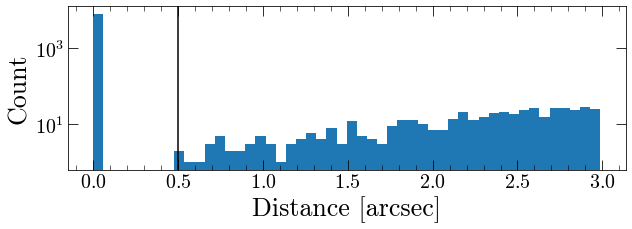

In [3]:
catalog = XMatch.query(cat1=catalog,
                     cat2='vizier:I/355/gaiadr3',
                     max_distance=3 * u.arcsec, colRA1='ra',
                     colDec1='dec')

plt.figure(figsize = (10,3))
plt.hist(catalog['angDist'], bins = 50)
plt.axvline(x = 0.5, c = 'k')
plt.xlabel('Distance [arcsec]')
plt.ylabel('Count')
plt.yscale('log')

catalog = catalog[catalog['angDist'] < 0.4]
catalog.rename_column('angDist', 'angDist_gaia')

In [4]:
catalog[0:3]

angDist_gaia,CATALOGID,ra,dec,SNR_SnowWhite,WD_TYPE,Teff_SnowWhite,E_Teff_SnowWhite,Logg_SnowWhite,E_Logg_SnowWhite,SPEC_FILE,DR3Name,RAdeg,DEdeg,errHalfMaj,errHalfMin,errPosAng,SolID,Source,RandomI,e_RAdeg,e_DEdeg,Plx,e_Plx,RPlx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RADEcor,RAPlxcor,RApmRAcor,RApmDEcor,DEPlxcor,DEpmRAcor,DEpmDEcor,PlxpmRAcor,PlxpmDEcor,pmRApmDEcor,NAL,NAC,NgAL,NbAL,gofAL,chi2AL,epsi,sepsi,Solved,APF,nueff,pscol,e_pscol,RApscolCorr,DEpscolCorr,PlxpscolCorr,pmRApscolCorr,pmDEpscolCorr,MatchObsA,Nper,amax,MatchObs,IPDgofha,IPDgofhp,IPDfmp,IPDfow,RUWE,Dup,o_Gmag,FG,e_FG,RFG,Gmag,e_Gmag,o_BPmag,FBP,e_FBP,RFBP,BPmag,e_BPmag,o_RPmag,FRP,e_FRP,RFRP,RPmag,e_RPmag,E(BP/RP),NBPcont,NBPblend,NRPcont,NRPblend,Mode,BP-RP,BP-G,G-RP,RV,e_RV,n_RV,o_RV,o_RVd,RVNper,RVS/N,RVgof,RVchi2,RVTdur,RVamp,RVtempTeff,RVtemplogg,RVtemp[Fe/H],Vatmparam,vbroad,e_Vbroad,o_Vbroad,GRVSmag,e_GRVSmag,o_GRVSmag,RVSS/N,VarFlag,PQSO,PGal,PSS,Teff,b_Teff,B_Teff,logg,b_logg,B_logg,[Fe/H],b_[Fe/H],B_[Fe/H],Dist,b_Dist,B_Dist,A0,b_A0,B_A0,AG,b_AG,B_AG,E(BP-RP),b_E(BP-RP),B_E(BP-RP),Lib,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,RADEcorJ2000
arcsec,,,,,,,,,,,,deg,deg,arcsec,arcsec,deg,,,,mas,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,deg,,,,,,electron/s,electron/s,,mag,,,electron/s,electron/s,,mag,,,electron/s,electron/s,,mag,,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,dex(cm / s2),dex,,km / s,km / s,,mag,mag,,,,,,,K,K,K,dex(cm / s2),dex(cm / s2),dex(cm / s2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,deg,deg,,,
float64,int64,float64,float64,float64,str4,float64,float64,float64,float64,str40,str28,float64,float64,float32,float32,float32,int64,int64,int32,float32,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,uint8,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,uint8,float32,int16,float32,float32,uint8,uint8,float32,uint8,int16,float64,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,float32,int16,int16,int16,int16,uint8,float32,float32,float32,float32,float32,uint8,int16,int16,uint8,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,uint8,float32,float32,int16,float32,str13,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str7,float64,float64,float64,float64,float32
0.009359,27021597834828397,319.59991455078125,67.87051391601562,3.50984525680542,DA,17801.755859375,551.94873046875,7.374729633331299,0.0027644874062389135,spec-101748-59846-27021597834828397.fits,Gaia DR3 2222278922912824704,319.59990818058,67.87051291589,0.0,0.0,13.0,1636148068921376768,2222278922912824704,373173182,0.2427,0.2859,1.8129,0.3421,5.2994,9.093,5.205,0.372,-7.456,0.315,0.0796,-0.0774,0.1724,0.0127,0.4069,-0.2119,-0.0328,-0.5064,0.1963,0.1127,245,0,245,0,0.6518,265.0,0.366,0.18229,31,False,1.717,--,--,--,--,--,--,--,28,21,0.542668,34,0.0132,57.2,0,0,1.028,0,269,292.56133,1.06506,274.691,19.521824,0.004818,32,200.568,6.50307,30.8421,19.582886,0.035313,31,128.863,7.15677,18.0057,19.472574,0.060418,1.126,0,0,0,0,0,0.110312,0.061062,0.04925,--,--,0,0,0,0,--,--,--,--,--,--,--,--,0,--,--,0,--,--,0,--,NOT_AVAILABLE,0.168559,1e-06,4.3e-05,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,,319.5998467685,67.87054605147,5.918496,5.057777,0.1247
0.039121,27021598788727984,292.24468994140625,2.056846857070923,--,DZ,--,--,--,--,spec-100527-59789-27021598788727984.fits,Gaia DR3 4287976811543910016,292.24470081482,2.05684676412,0.001,0.0,50.0,1636148068921376768,4287976811543910016,1144609251,0.4201,0.3767,6.3444,0.4221,15.0307,50.745,-40.044,0.482,-31.169,0.432,0.5862,-0

In [5]:
catalog['parallax_over_error'] = catalog['Plx'] / catalog['e_Plx']
catalog = catalog[catalog['parallax_over_error'] > 20]

In [6]:
from astroquery.gaia import Gaia

ADQL_CODE1 = """SELECT dist.source_id, dist.r_med_geo
        FROM gaiadr3.gaia_source as gaia
        JOIN external.gaiaedr3_distance as dist
        ON gaia.source_id = dist.source_id      
        WHERE gaia.source_id in {}""".format(tuple(catalog['Source']))
gaia_d1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results()
        
catalog = join(catalog, gaia_d1, keys_left = 'Source', keys_right = 'source_id')

In [7]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pyphot
import extinction

#catalog['r_med_geo'] = 100 / catalog['PARALLAX']

# Coordinates using inverted parallax distances
coords = [SkyCoord(frame="icrs", ra=catalog['ra'][i]*u.deg, dec=catalog['dec'][i]*u.deg, distance = catalog['r_med_geo'][i] * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords


# Query Edenhofer2023 to get E(B-V) in arbitrary units
bsq = Edenhofer2023Query()
bsq_res = bsq.query(catalog['wd_coords']).copy()
bsq_res[np.isnan(bsq_res)] = 0

# Convert to actual units
Ebv = bsq_res*0.901*0.98
e_Ebv = Ebv*0.2

catalog['E(B-V)'] = Ebv
catalog['e_E(B-V)'] = e_Ebv


# Parameters for correcting using Gaia
Rv = 3.1
catalog['A_v0'] = catalog['E(B-V)']*Rv

# Fetch Gaia photometric band wavelengths and store in `gaia_phot_wavl`
lib = pyphot.get_library()
gaia_phot = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP']]
gaia_phot_wavl = np.array([x.lpivot.to('angstrom').value for x in gaia_phot])


# For each point, find extinction using the parameters we defined above
ext_all = []
for av0 in catalog['A_v0']:
    ext_all.append( extinction.fitzpatrick99(gaia_phot_wavl, av0, Rv) )
ext_all = np.array(ext_all)
    
# Save the extinction in each band
catalog['BP_ext'] = ext_all.T[0]
catalog['RP_ext'] = ext_all.T[1]

# Subtract out the extinction to find de-reddened magnitude
catalog['GAIA_G'] = catalog['Gmag'] - catalog['BP_ext']
catalog['GAIA_BP'] = catalog['BPmag'] - catalog['BP_ext']
catalog['GAIA_RP'] = catalog['RPmag'] - catalog['RP_ext']

Optimizing map for querying (this might take a couple of seconds)...


In [8]:
catalog['abs_g'] = catalog['GAIA_G'] - 5 * np.log10(catalog['r_med_geo']) + 5
catalog['abs_bp'] = catalog['GAIA_BP'] - 5 * np.log10(catalog['r_med_geo']) + 5
catalog['abs_rp'] = catalog['GAIA_RP'] - 5 * np.log10(catalog['r_med_geo']) + 5

catalog['bp_rp'] = catalog['abs_bp'] - catalog['abs_rp']

catalog['distance'] = catalog['r_med_geo']

In [9]:
from pyphot import unit


base_wavl, tremblay, table = corv.utils.build_montreal_da(path = '/home/sarsene1/corv/src/corv/models/montreal_da', flux_unit = 'flam')

bp_g = []
g_rp = []

lib = pyphot.get_library()
filters = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP']]

logg = 8
teffs = np.linspace(5000, 100000, 100)

for i in tqdm(range(len(teffs))):
    spec = tremblay((teffs[i], logg))
    
    fluxes = [filters[j].get_flux(base_wavl * unit['angstrom'], spec* unit['erg/s/cm**2/angstrom'], axis=1).to('erg/s/cm**2/angstrom').value for j in range(len(filters))]
    mags = [-2.5 * np.log10(fluxes[j]) - filters[j].Vega_zero_mag for j in range(len(filters))]
    
    bp_g.append(mags[1] - mags[0])
    g_rp.append(mags[0] - mags[2])
    
bp_g = list(reversed(bp_g))
g_rp = list(reversed(g_rp))
    
catalog['diffs'] = catalog['G-RP'] - np.interp(catalog['BP-G'], bp_g, g_rp)

100%|██████████| 100/100 [00:01<00:00, 54.97it/s]


Text(0.5, 0, 'Fontaine+2001 $G-RP$ Bias')

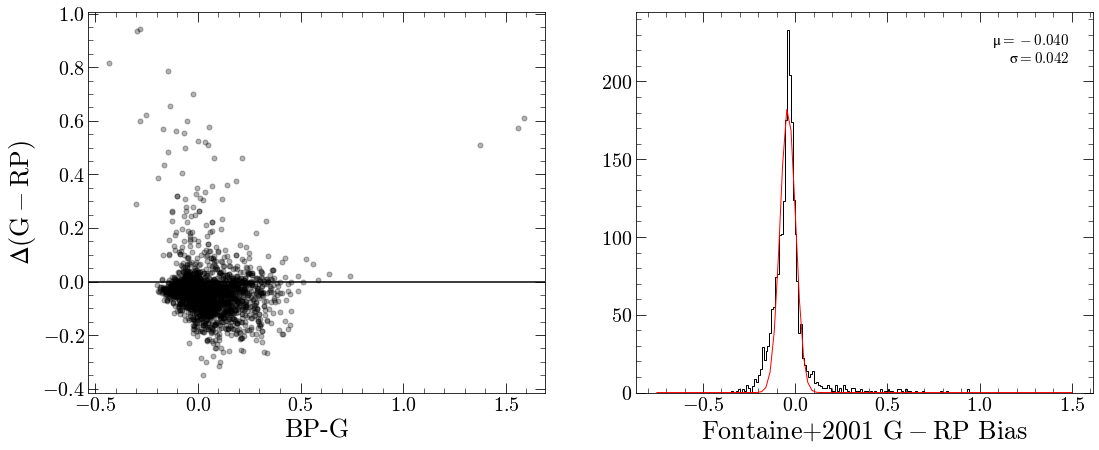

In [12]:
from scipy.optimize import leastsq
fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2)
errfunc  = lambda p, x, y: (y - fitfunc(p, x))
init  = [10.0, 0.5, 5]
domain = np.linspace(-0.75,1.5,100)

mask = np.all([catalog['diffs'] < 0.1, catalog['diffs'] > -0.1], axis = 0)

plt.figure(figsize=(18,7))

plt.subplot(1,2,1)

plt.scatter(catalog['BP-G'], catalog['diffs'], c = 'k', alpha = 0.3)
plt.axhline(y = 0, c = 'k')

plt.xlabel('BP-G')
plt.ylabel('$\Delta(G - RP)$')

plt.subplot(1,2,2)

n, bins, patches = plt.hist(catalog['diffs'], color = 'k',histtype='step')

x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]
init  = [20.0, 0.5, 5]


out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='r', linewidth = 1)

plt.text(0.95, 0.95, r'$\mu = %.3f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.3f$' % np.average( np.abs(c[2]) ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlabel('Fontaine+2001 $G-RP$ Bias')

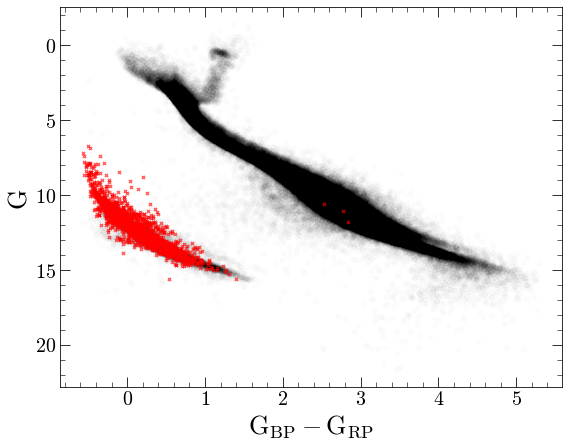

In [11]:
allstars = Table.read('data/allstars.dat.gz', format='ipac')


plt.figure(figsize=(9,7))

plt.scatter(allstars['abs_bp'] - allstars['abs_rp'], allstars['abs_g'], c = 'k', alpha = 0.01)
plt.scatter(catalog['abs_bp'] - catalog['abs_rp'], catalog['abs_g'],  c = 'red', alpha = 0.6, marker = 'x', s = 10, label = 'SDSS-V White Dwarfs')

plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel('G')
plt.gca().invert_yaxis()